In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, mcoe, analysis, constants, settings, outputs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
# What is this chained_assignment thing all about?
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [3]:
pudl_engine  = pudl.connect_db()

## Pull and Prepare Data

In [4]:
g9_summed = mcoe.generation_pull_eia923(pudl_engine, years=[2014, 2015, 2016])
g8, g8_es = mcoe.generators_pull_eia860(pudl_engine, years=[2014, 2015, 2016])
frc9_summed, frc9_summed_plant = mcoe.fuel_reciepts_costs_pull_eia923(pudl_engine, years=[2014, 2015, 2016])
bga8 = mcoe.boiler_generator_pull_eia860(pudl_engine)
bf9_summed, bf9_plant_summed = mcoe.boiler_fuel_pull_eia923(pudl_engine, years=[2014, 2015, 2016])

In [9]:
plant_id = 'plant_id_eia'
min_heat_rate = 5.5
#hr_years = [2014, 2015, 2016,]
hr_years = []
#g9_summed = g9_summed_orig[g9_summed_orig.report_year.isin(hr_years)]
#g8 = g8_orig[g8_orig.report_year.isin(hr_years)]
#g8_es = g8_es_orig[g8_es_orig.report_year.isin(hr_years)]
#frc9_summed = frc9_summed_orig[frc9_summed_orig.report_year.isin(hr_years)]
#frc9_summed_plant = frc9_summed_plant_orig[frc9_summed_plant_orig.report_year.isin(hr_years)]
#bf9_summed = bf9_summed_orig[bf9_summed_orig.report_year.isin(hr_years)]
#bf9_plant_summed = bf9_plant_summed_orig[bf9_plant_summed_orig.report_year.isin(hr_years)]

## Do the Heat Rate Calculations

In [25]:
# Just for reference...
hr_old = mcoe.heat_rate_old(bga8, g9_summed, bf9_summed,
                            bf9_plant_summed, pudl_engine,
                            id_col='plant_id_eia', min_heat_rate=-1000)

# Calculate heat rates for unassociated plants:
hru = mcoe.heat_rate_unassn(bga8, g9_summed, bf9_summed,
                            bf9_plant_summed, pudl_engine,
                            plant_id='plant_id_eia')

# Calculate heat rates for associated plants:
hra = mcoe.heat_rate_assn(bga8, g9_summed, bf9_summed,
                          bf9_plant_summed, pudl_engine,
                          plant_id='plant_id_eia')

# Dissociate all the plants, and calculate heat rates at
# the plant level:
hrd = mcoe.heat_rate_unassn(bga8, g9_summed, bf9_summed,
                            bf9_plant_summed, pudl_engine,
                            plant_id='plant_id_eia', dissociate=True)

# Identify which plants (either associated or unassociated) are
# apparently "contaminated" by virtue of having obviously wrong
# heat rates. This means their boiler/generator mappings or data
# have something wonky going on:
bad_plants_assoc = hra[hra.heat_rate_mmbtu_mwh < min_heat_rate][plant_id].unique()
bad_plants_unassoc = hru[hru.heat_rate_mmbtu_mwh < min_heat_rate][plant_id].unique()
bad_plants = np.append(bad_plants_assoc, bad_plants_unassoc)

# Use that master list of "bad plants" to sort both the associated
# and unassociated plants into usable and unusable data:
hra_bad = hra[hra[plant_id].isin(bad_plants)]
hra_good = hra[~hra[plant_id].isin(bad_plants)]
hru_bad = hru[hru[plant_id].isin(bad_plants)]
hru_good = hru[~hru[plant_id].isin(bad_plants)]

one_fuel_plants = g8_es[g8_es['energy_source_count'] == 1][plant_id]

# There are several reasons that a plant might have ended up
# in the "bad" plants -- i.e. those with any generator level
# heat rates below the minimum plausible heat rate value.
# Sometimes this is because there's truly missing data, like
# fuel that was delivered and burned, but which doesn't show up
# in the boiler fuel table -- there's no getting around that.
# Other times, it's because the boiler/generator mapping was
# messed up somehow. By looking at the plant level average heat
# rates, we can still get some useful information out of the plant
# if all of the fuel & generation were reported.
hrd_leftover = hrd[(hrd[plant_id].isin(bad_plants))]

# If there's more than one fuel... then we can't effectively screen
# based on heat rate -- zero + high can average out to "reasonable"
bad_hrd_mask = ((~hrd_leftover[plant_id].isin(one_fuel_plants)) |
                (hrd_leftover.heat_rate_mmbtu_mwh < min_heat_rate))
hrd_bad = hrd_leftover[bad_hrd_mask]
hrd_fix = hrd_leftover[~bad_hrd_mask]

# Tag the records so we know what kind they are
hra_good['heatrate_calc'] = 'associated_good'
hru_good['heatrate_calc'] = 'unassociated_good'
hrd_fix['heatrate_calc'] = 'dissociated_fix'

# Compile the usable heatrates into one dataframe
hr_good = pd.concat([hra_good, hru_good, hrd_fix])

In [7]:
def hr_hist(hr_dfs, labels, bins=200, range=(0,20), weighted=True,
            title="Heat Rates", save=False, outfile='heatrate.png', alpha=1.0, years=None):
    for hr_df, label in zip(hr_dfs, labels):
        df = hr_df[['report_year','heat_rate_mmbtu_mwh','net_generation_mwh']].dropna()
        if len(years) > 0:
            df = df[df.report_year.isin(years)]
        if weighted:
            weights = df.net_generation_mwh
            ylabel = 'MWh generated'
        else:
            weights=None
            ylabel = 'generator-years'
        plt.hist(df.heat_rate_mmbtu_mwh, weights=weights,
                 bins=bins, range=range, label=label, alpha=alpha)
    if(len(years) == 1):
        yrstr = str(years[0])
    else:
        yrstr = str(min(df.report_year.unique())) + '-' + str(max(df.report_year.unique()))
    title = title + ', ' + yrstr
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Heat Rate (mmBTU/MWh)')
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(outfile)
    plt.show()

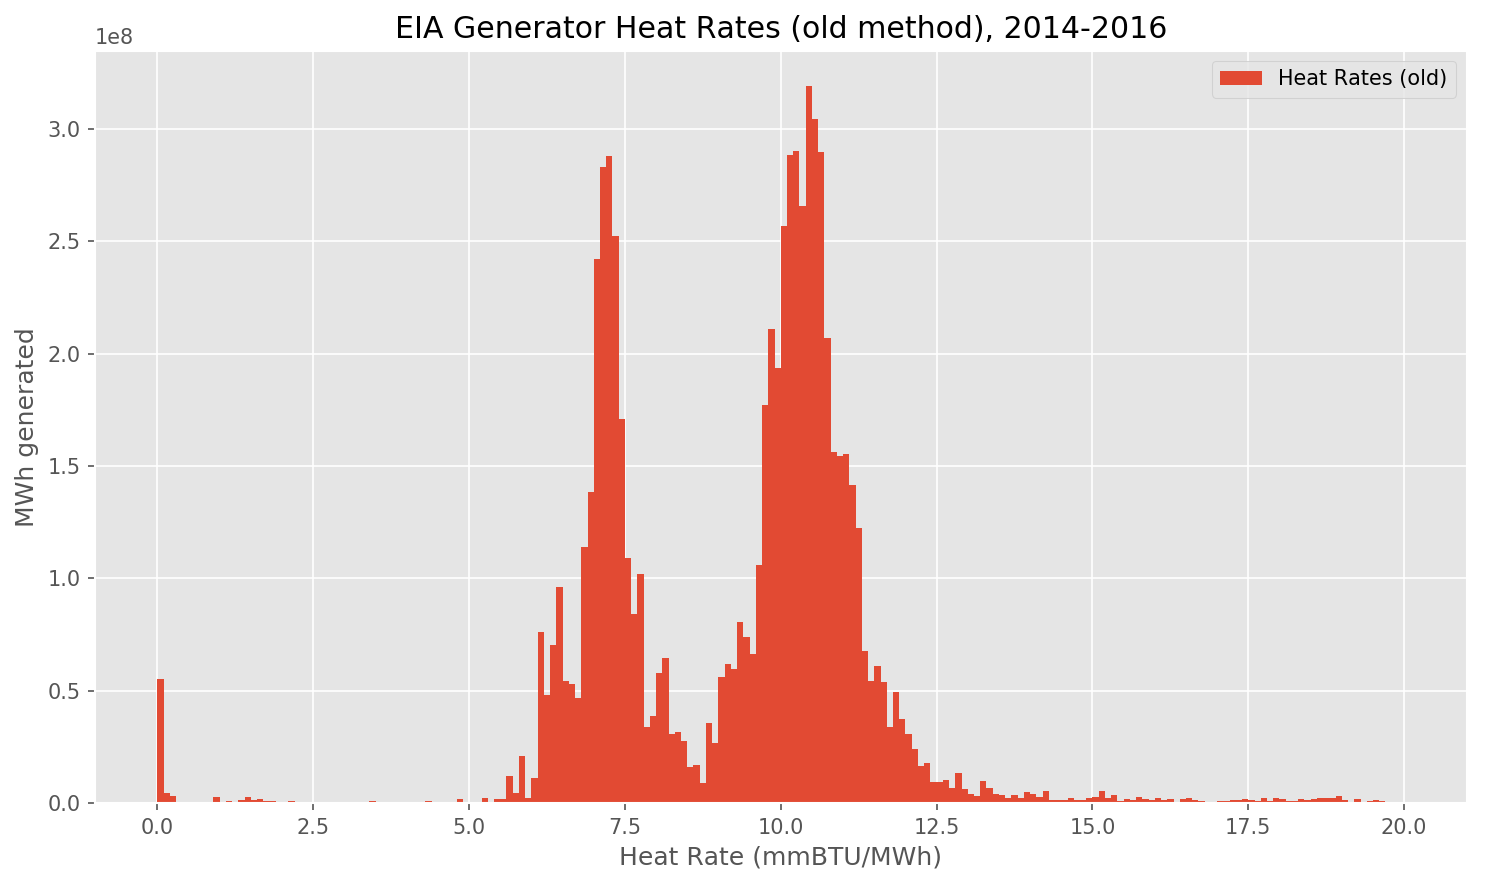

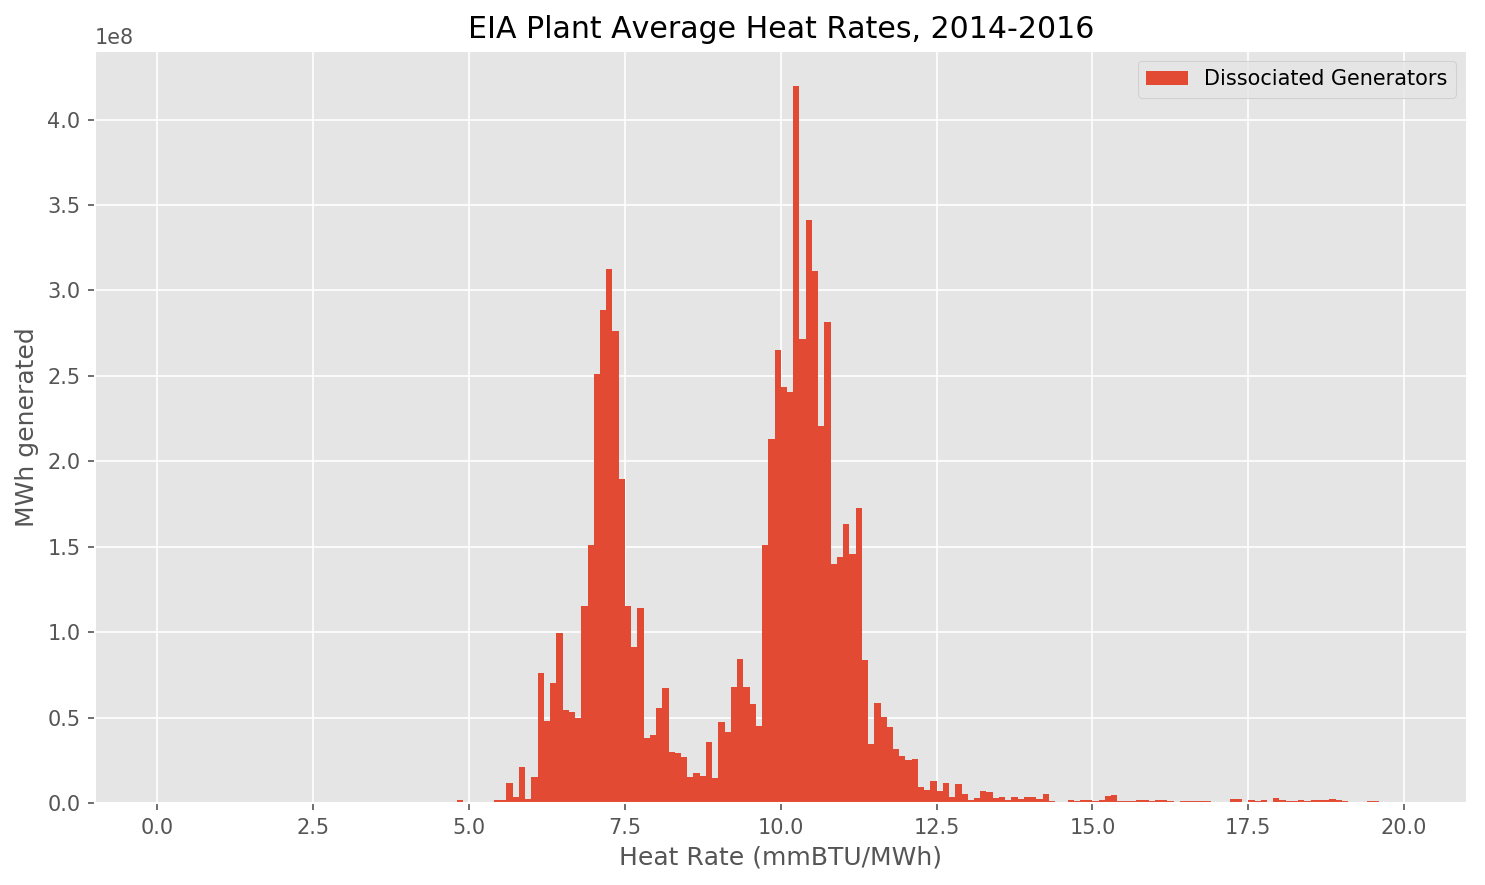

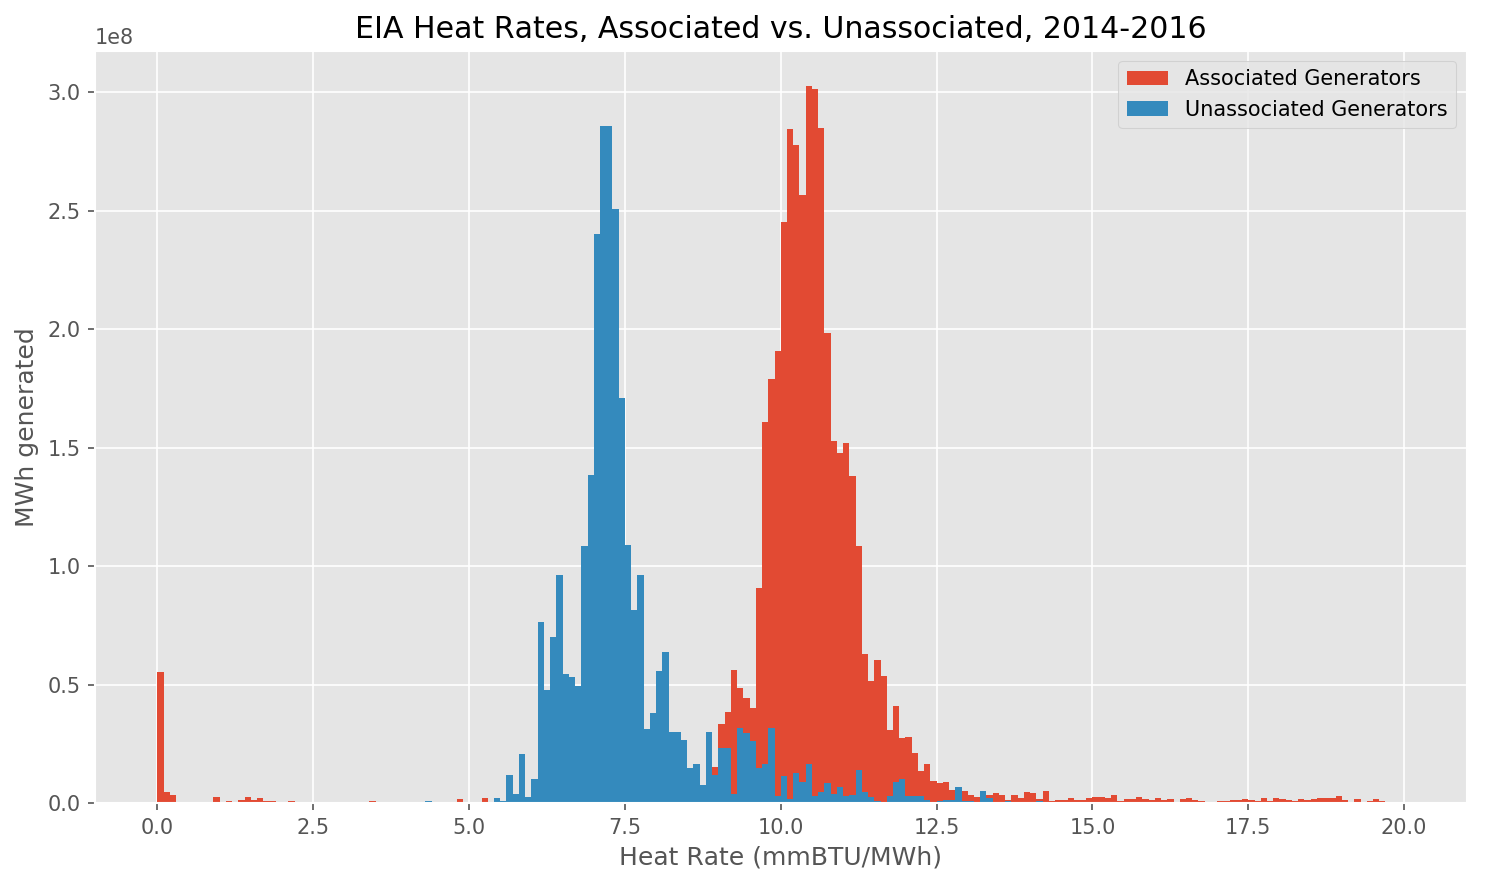

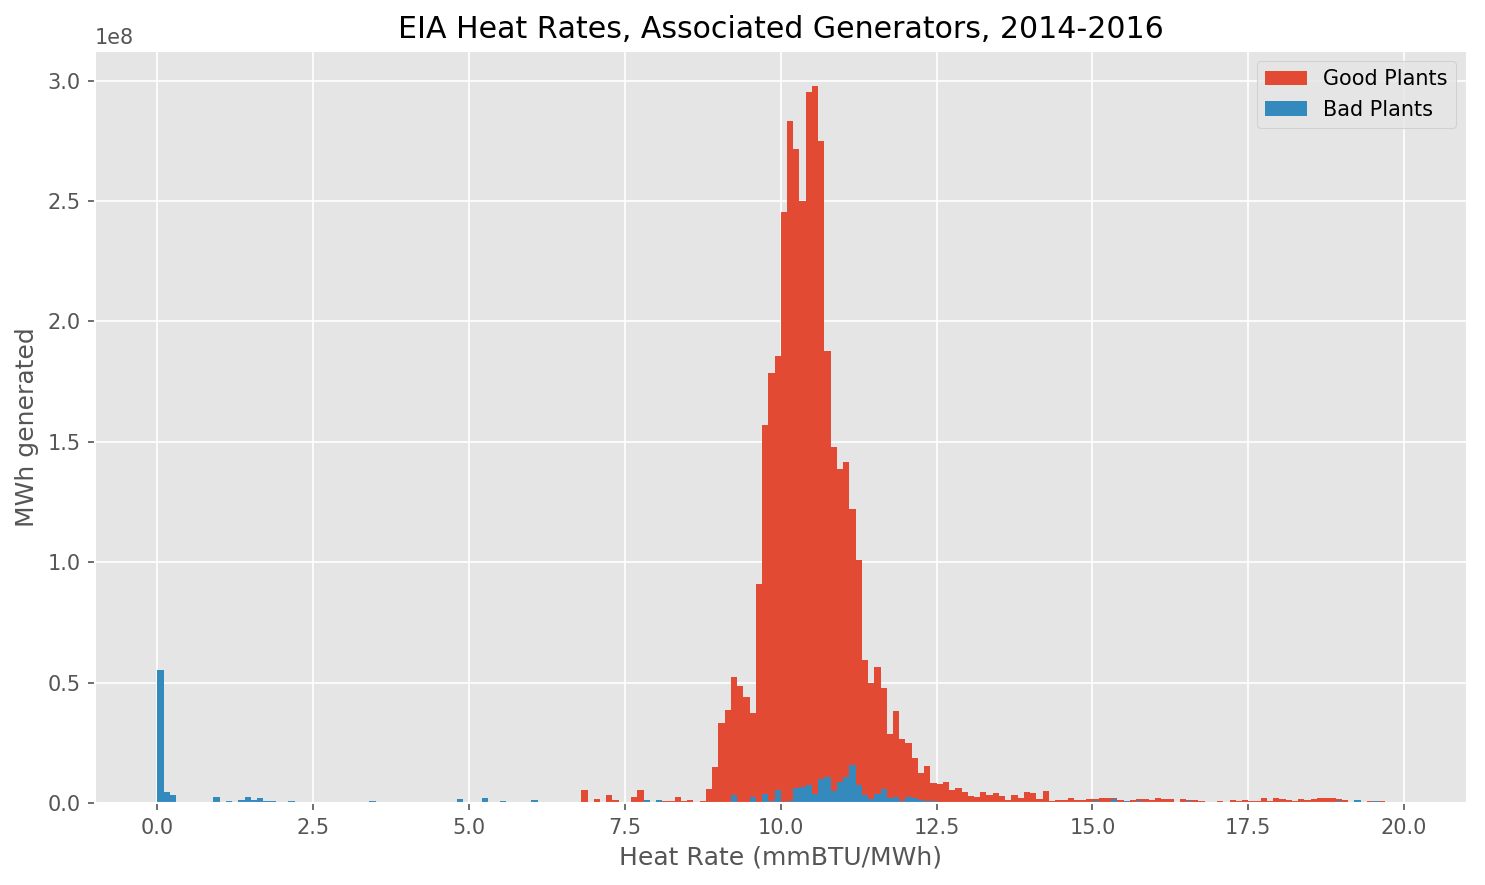

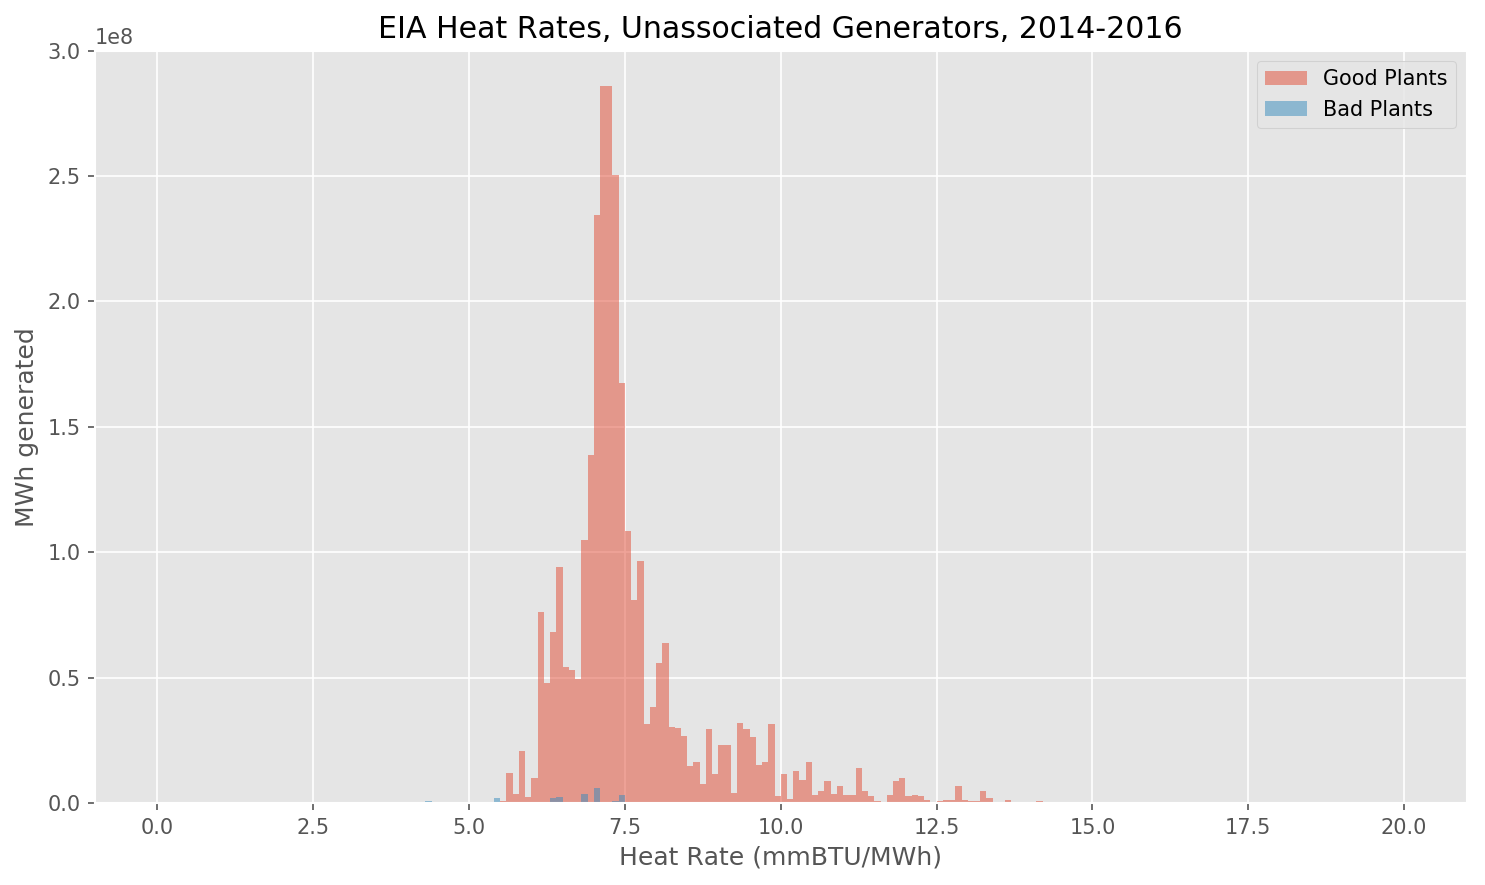

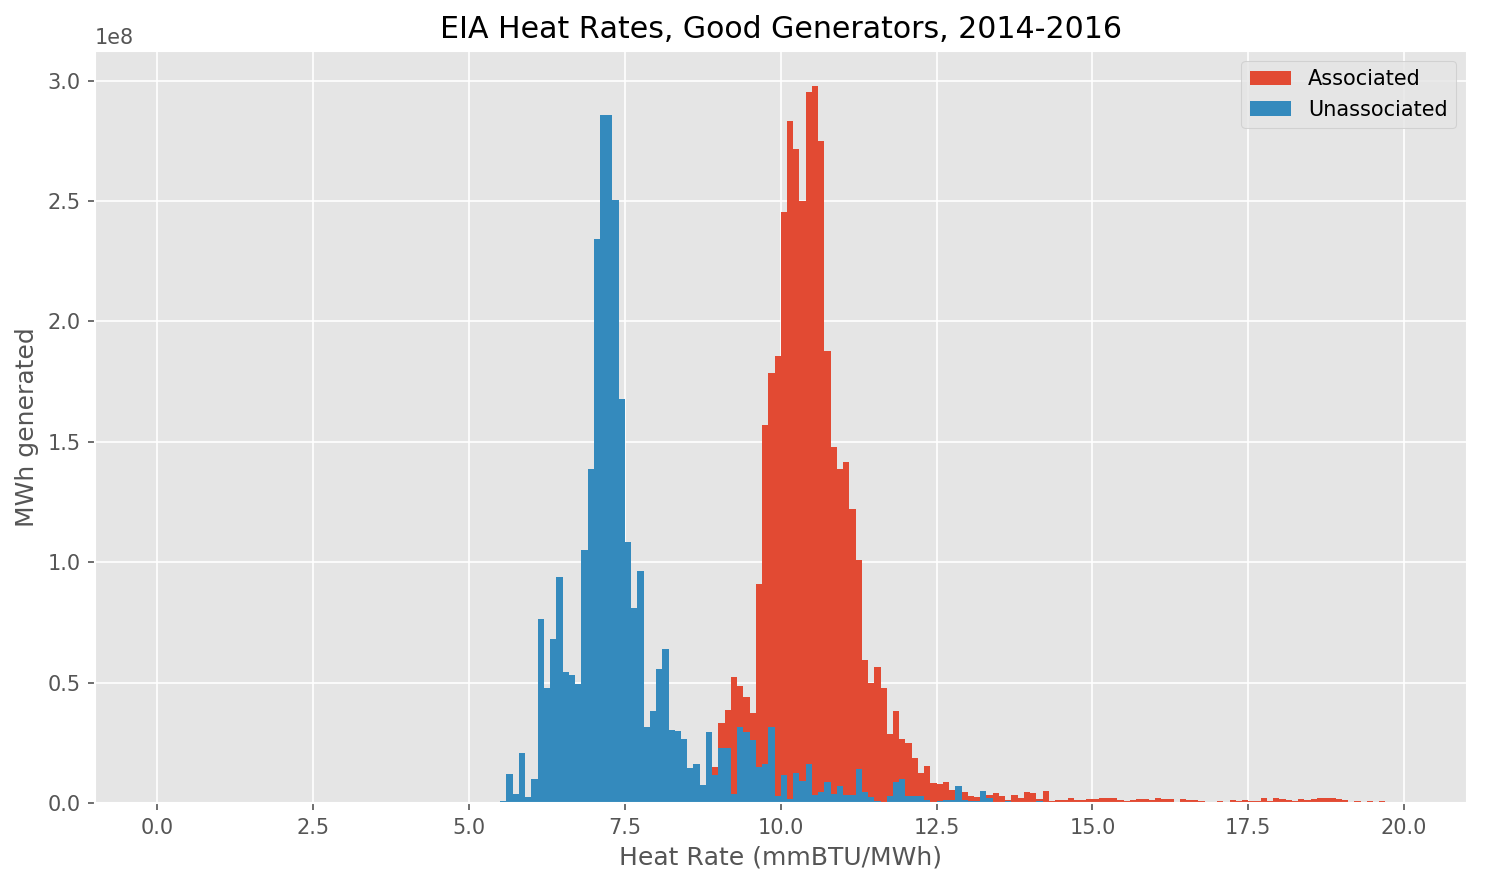

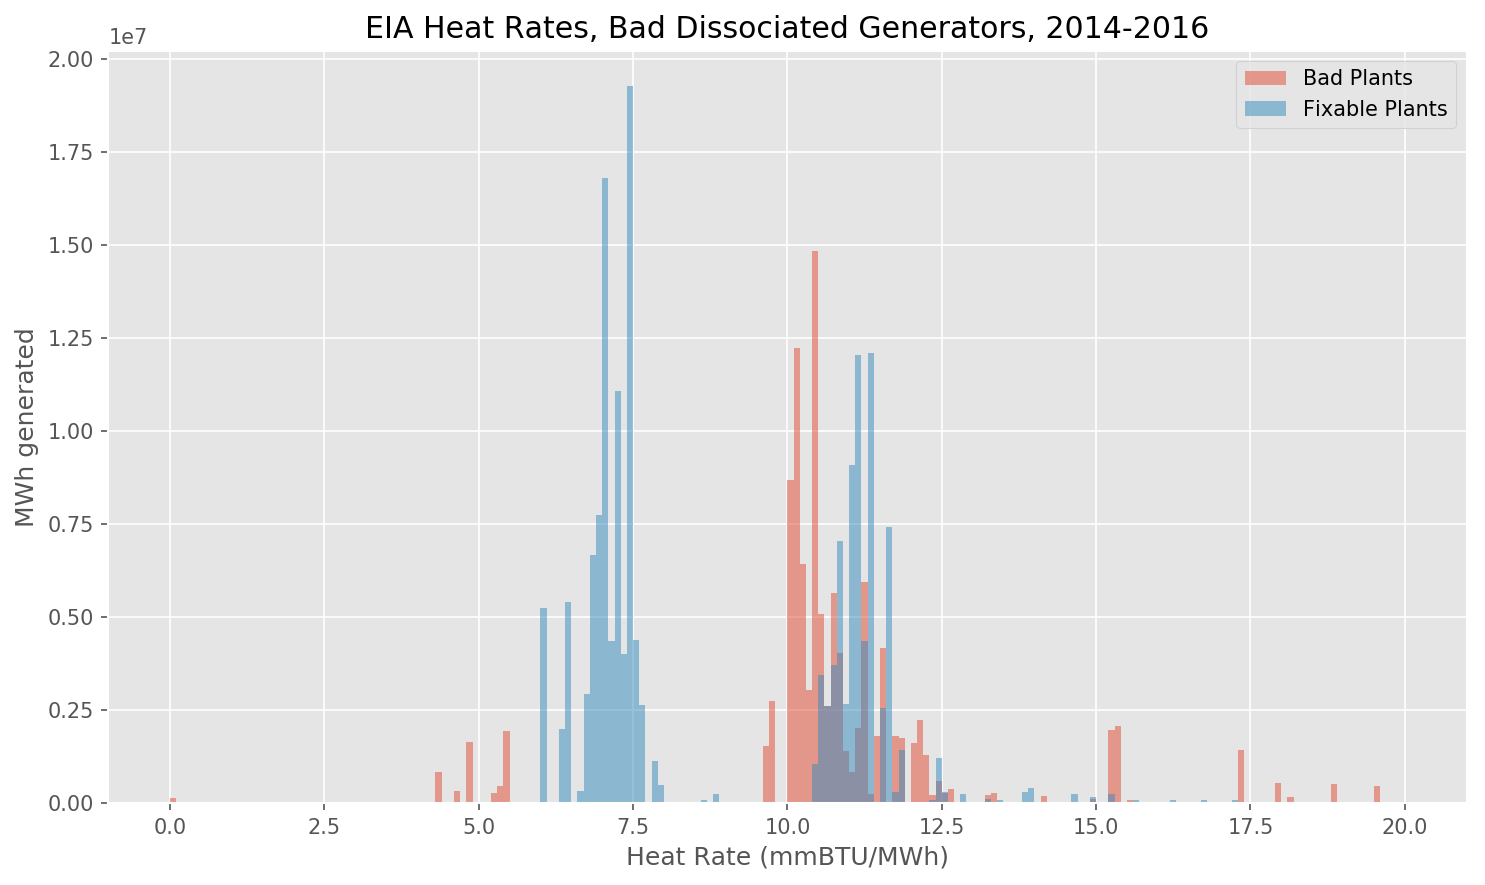

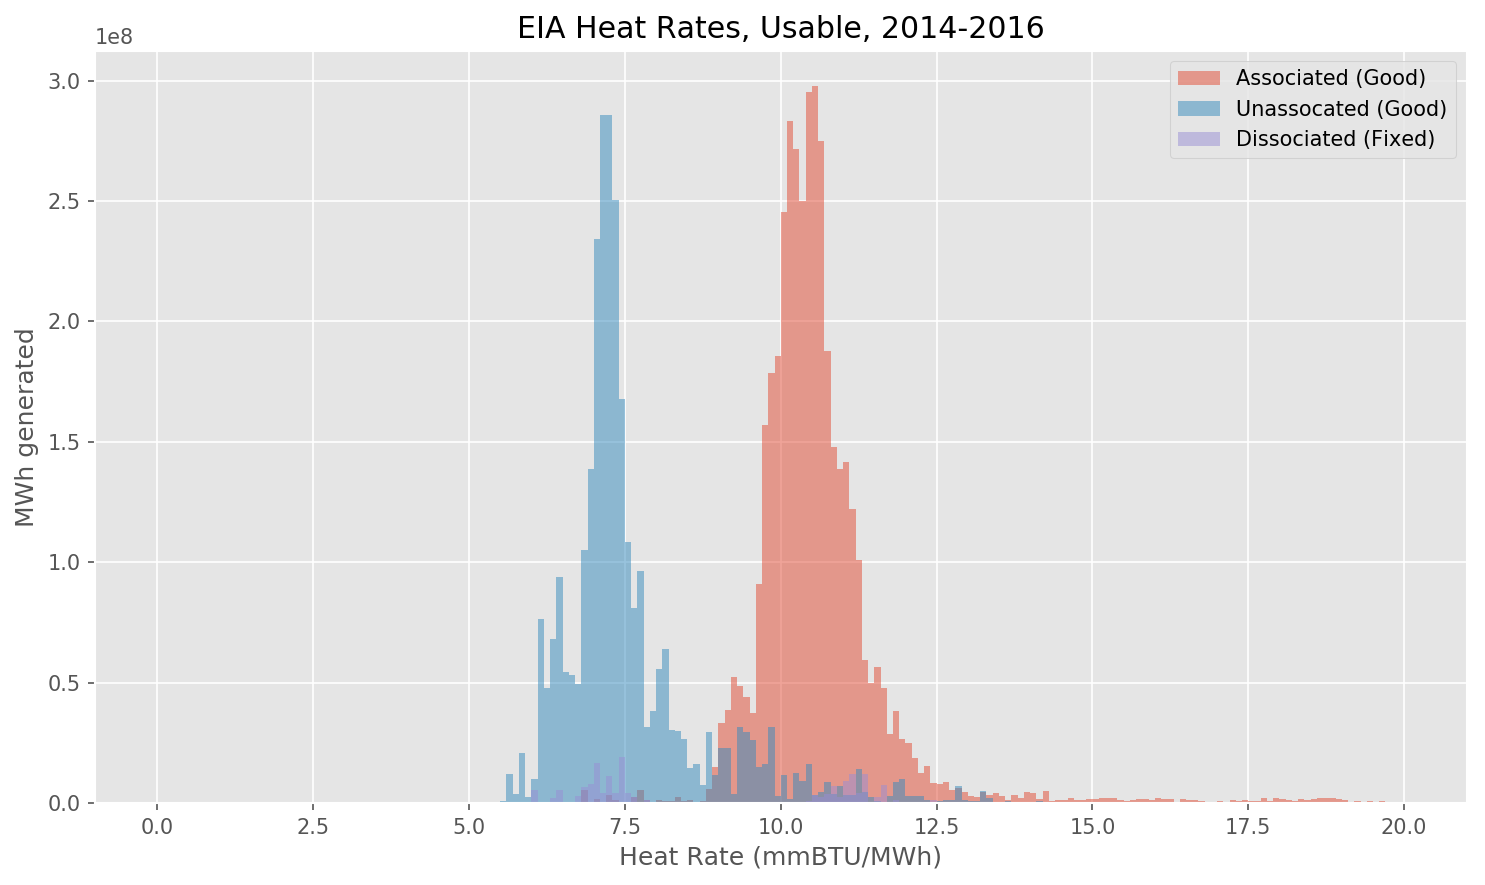

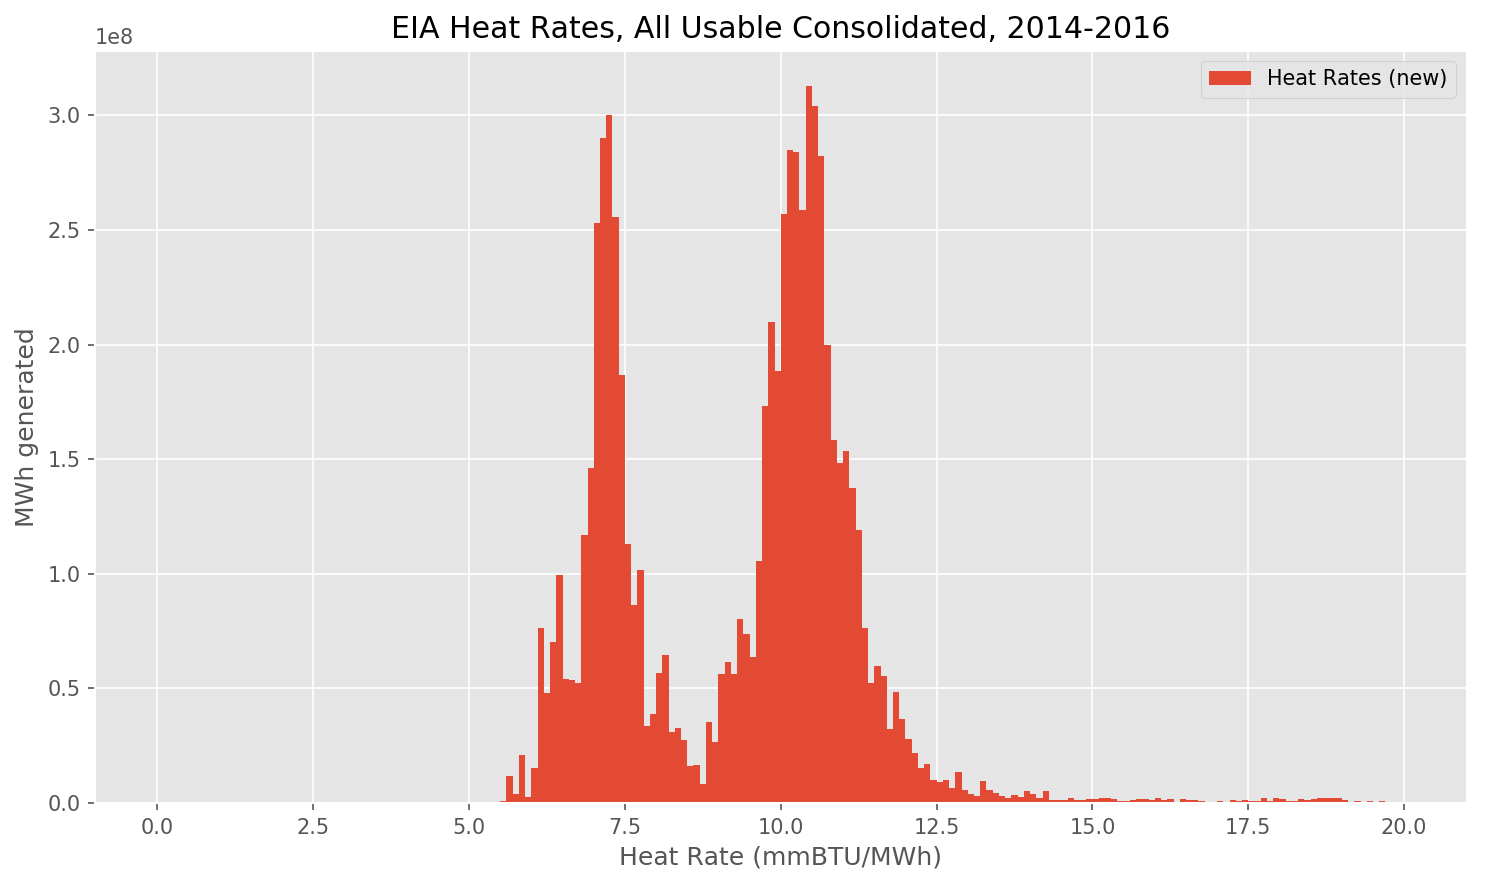

In [10]:
hr_save=True
savedir = 'heatrate_figs'
hist_range = (0,20)
nbins = 200

hr_hist([hr_old,], labels=['Heat Rates (old)'],
        title='EIA Generator Heat Rates (old method)',
        range=hist_range, bins=nbins, years=hr_years,
        save=hr_save, outfile='{}/01-Heat Rates (OLD).png'.format(savedir))

hr_hist([hrd,], labels=['Dissociated Generators'],
        title='EIA Plant Average Heat Rates',
        range=hist_range, bins=nbins, years=hr_years,
        save=hr_save, outfile='{}/02-Heat Rates (Dissociated).png'.format(savedir))

hr_hist([hra, hru], labels=['Associated Generators', 'Unassociated Generators'],
        title='EIA Heat Rates, Associated vs. Unassociated',
        range=hist_range, bins=nbins, years=hr_years,
        save=hr_save, outfile='{}/03-Heat Rates (Associated + Unassociated).png'.format(savedir))

hr_hist([hra_good, hra_bad], labels=['Good Plants', 'Bad Plants'],
        title='EIA Heat Rates, Associated Generators',
        range=hist_range, bins=nbins, years=hr_years,
        save=hr_save, outfile='{}/04-Heat Rates (Associated Good + Bad).png'.format(savedir))

hr_hist([hru_good, hru_bad], labels=['Good Plants', 'Bad Plants'],
        title='EIA Heat Rates, Unassociated Generators',
        range=hist_range, bins=nbins, alpha=0.5, years=hr_years,
        save=hr_save, outfile='{}/05-Heat Rates (Unassociated Good + Bad).png'.format(savedir))

hr_hist([hra_good, hru_good], labels=['Associated', 'Unassociated'],
        title='EIA Heat Rates, Good Generators',
        range=hist_range, bins=nbins, years=hr_years,
        save=hr_save, outfile='{}/06-Heat Rates (Good Associated + Unassociated).png'.format(savedir))

hr_hist([hrd_bad, hrd_fix], labels=['Bad Plants', 'Fixable Plants'],
        title='EIA Heat Rates, Bad Dissociated Generators',
        range=hist_range, bins=nbins, alpha=0.5, years=hr_years,
        save=hr_save, outfile='{}/07-Heat Rates (Dissociated Bad + Fixed).png'.format(savedir))

hr_hist([hra_good, hru_good, hrd_fix], labels=['Associated (Good)', 'Unassocated (Good)', 'Dissociated (Fixed)'],
        title='EIA Heat Rates, Usable',
        range=hist_range, bins=nbins, alpha=0.5, years=hr_years,
        save=hr_save, outfile='{}/08-Heat Rates (Good + Fixed).png'.format(savedir))

hr_hist([hr_good], labels=['Heat Rates (new)'],
        title='EIA Heat Rates, All Usable Consolidated',
        range=hist_range, bins=nbins, years=hr_years,
        save=hr_save, outfile='{}/09-Heat Rates (All Usable).png'.format(savedir))

In [21]:
len(hr_good[['plant_id_eia','generator_id']].drop_duplicates())

4148

In [17]:
gens_eia860 = outputs.generators_eia860(pudl_engine)
gens_eia860 = gens_eia860[gens_eia860.report_year.isin([2014, 2015, 2016])]
gas_ct_techs = ['Natural Gas Fired Combustion Turbine', ]
gas_cc_techs = ['Natural Gas Fired Combined Cycle', ]
gas_st_techs = ['Natural Gas Steam Turbine', ]
coal_st_techs = ['Conventional Steam Coal', ]
gas_ct_gens_eia860 = gens_eia860[gens_eia860.technology.isin(gas_ct_techs)]
gas_cc_gens_eia860 = gens_eia860[gens_eia860.technology.isin(gas_cc_techs)]
gas_st_gens_eia860 = gens_eia860[gens_eia860.technology.isin(gas_st_techs)]
coal_st_gens_eia860 = gens_eia860[gens_eia860.technology.isin(coal_st_techs)]

In [18]:
[x for x in gens_eia860.technology.unique()]

['Conventional Steam Coal',
 'Natural Gas Steam Turbine',
 'Conventional Hydroelectric',
 'Petroleum Liquids',
 'Natural Gas Fired Combined Cycle',
 'Other Waste Biomass',
 'Natural Gas Fired Combustion Turbine',
 'Natural Gas Internal Combustion Engine',
 'Natural Gas with Compressed Air Storage',
 'Nuclear',
 'Onshore Wind Turbine',
 'All Other',
 'Landfill Gas',
 'Municipal Solid Waste',
 'Geothermal',
 'Hydroelectric Pumped Storage',
 'Batteries',
 'Wood/Wood Waste Biomass',
 'Solar Photovoltaic',
 'Solar Thermal without Energy Storage',
 None,
 'Other Gases',
 'Other Natural Gas',
 'Petroleum Coke',
 'Coal Integrated Gasification Combined Cycle',
 'Offshore Wind Turbine',
 'Flywheels',
 'Solar Thermal with Energy Storage',
 'Hydrokinetic']

In [26]:
hr_good = pd.merge(hr_good, gens_eia860[['report_year','plant_id','generator_id','technology']],
         left_on=['report_year','plant_id_eia', 'generator_id'],
         right_on=['report_year','plant_id','generator_id'],
         how='left')

In [24]:
hr_good.columns

Index(['boiler_generator_assn', 'boiler_id', 'complete_assn',
       'fuel_consumed_mmbtu_generator', 'generator_id', 'heat_rate_mmbtu_mwh',
       'heatrate_calc', 'net_generation_mwh', 'plant_assn', 'plant_id_eia',
       'plant_id_pudl', 'report_year', 'plant_id_x', 'technology_x',
       'plant_id_y', 'technology_y', 'plant_id', 'technology'],
      dtype='object')

In [27]:
hr_gas_ct = hr_good[hr_good.technology.isin(gas_ct_techs)]
hr_gas_cc = hr_good[hr_good.technology.isin(gas_cc_techs)]
hr_gas_st = hr_good[hr_good.technology.isin(gas_st_techs)]
hr_coal_st = hr_good[hr_good.technology.isin(coal_st_techs)]

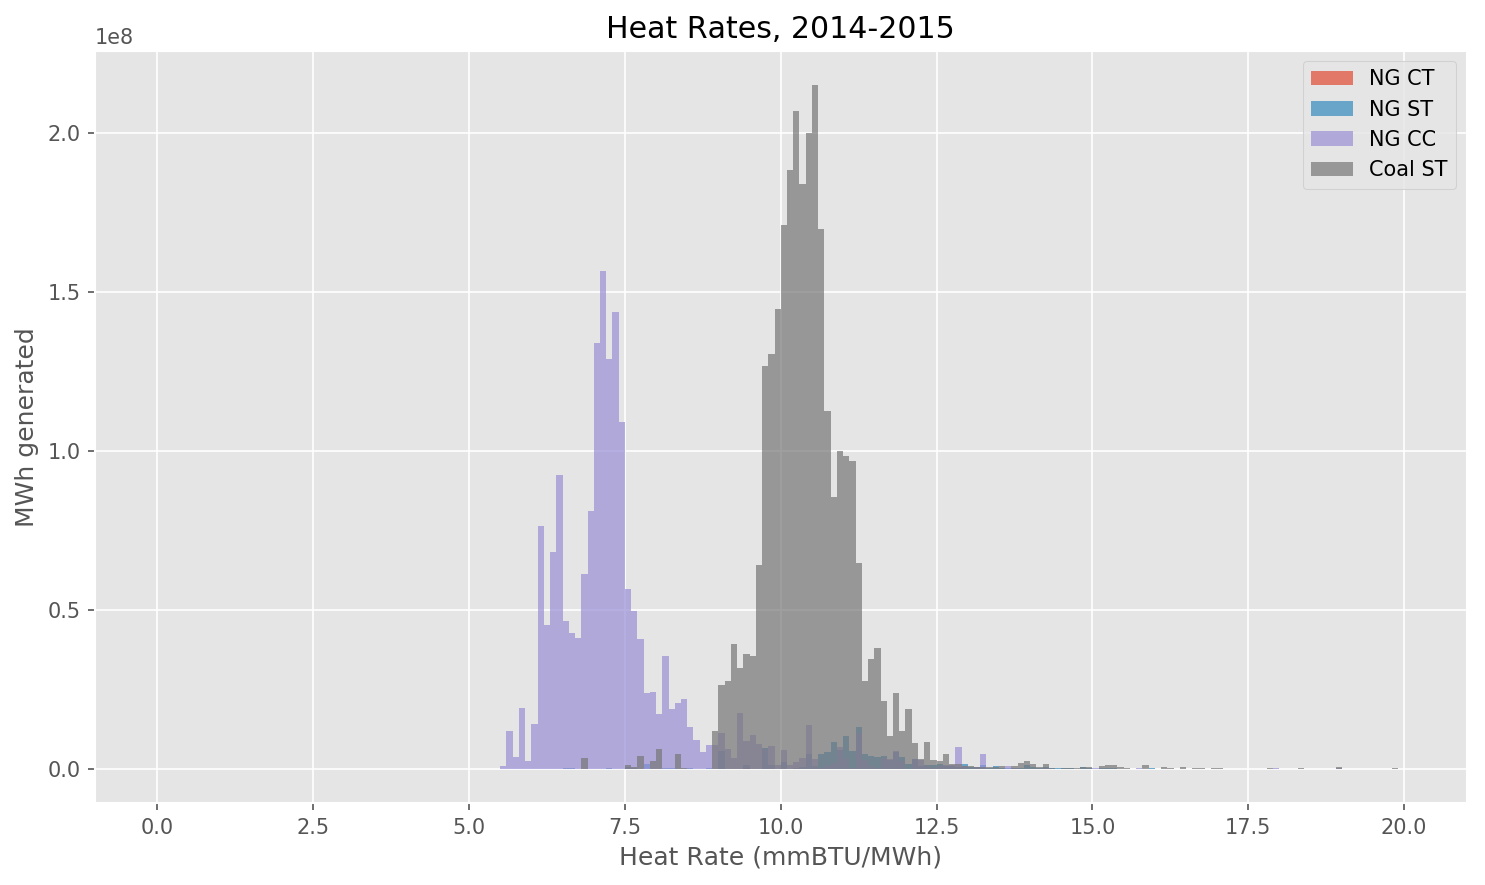

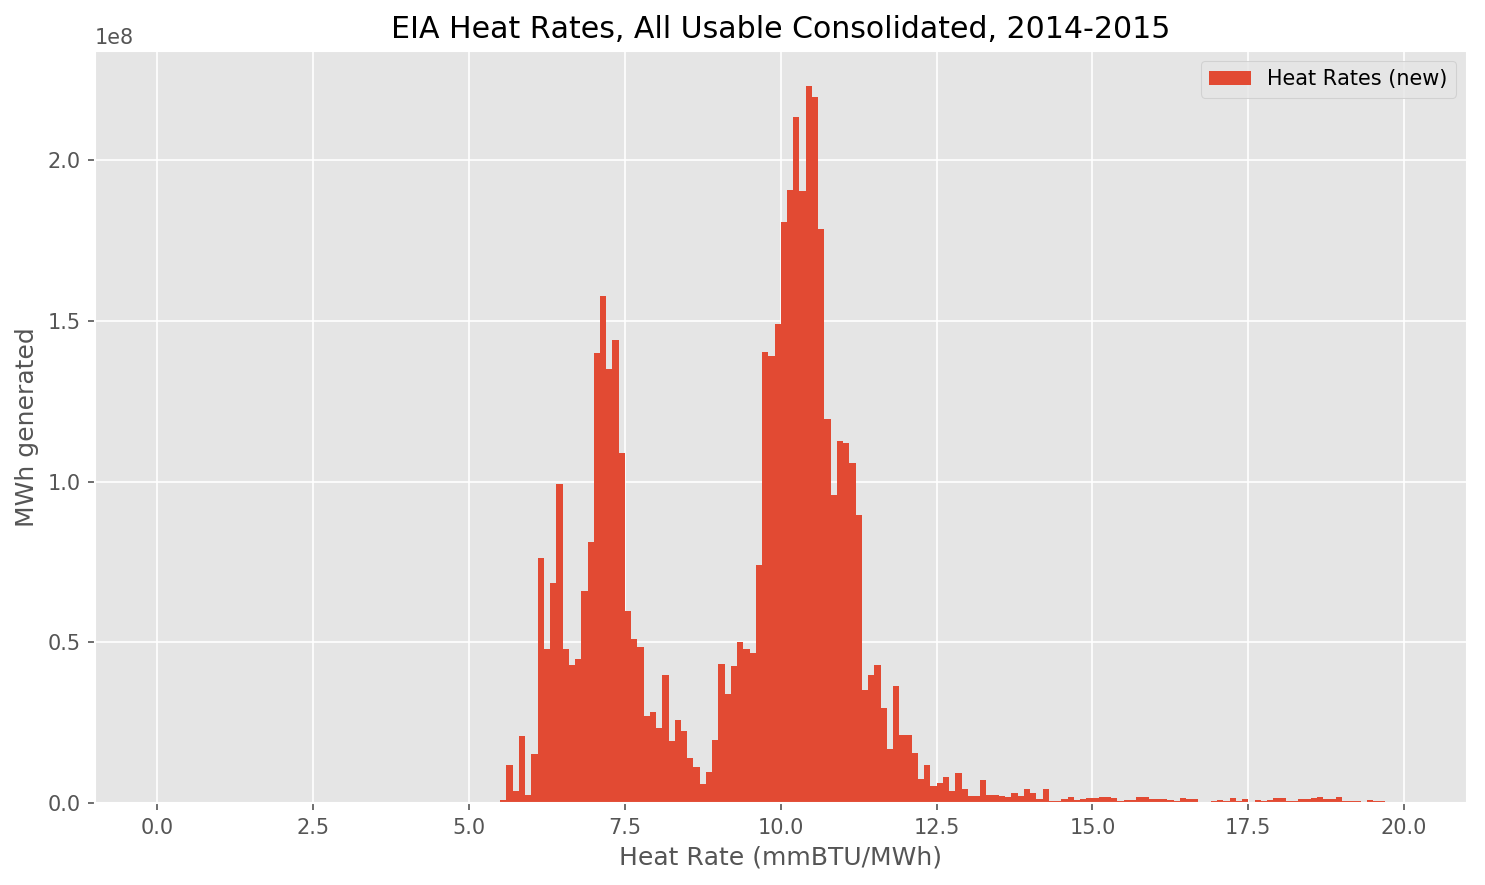

In [28]:
hr_hist([hr_gas_ct, hr_gas_st, hr_gas_cc, hr_coal_st],
        labels=['NG CT', 'NG ST', 'NG CC', 'Coal ST'],
        alpha=0.7, years=[2014,2015], save=True, outfile='{}/10-Heat Rates (Good, by Technology)'.format(savedir))

hr_hist([hr_good], labels=['Heat Rates (new)'],
        title='EIA Heat Rates, All Usable Consolidated',
        range=hist_range, bins=nbins, years=[2014,2015],
        save=hr_save, outfile='{}/09-Heat Rates (All Usable).png'.format(savedir))

### Heat Rate

In [29]:
heat_rate = mcoe.heat_rate(g8_es, bga8, g9_summed, bf9_summed, bf9_plant_summed, pudl_engine, plant_id='plant_id_eia')
ordered_cols = [
    'report_year',
    'plant_id_eia',
    'plant_id_pudl',
    'generator_id',
    'fuel_consumed_mmbtu_generator',
    'net_generation_mwh',
    'heat_rate_mmbtu_mwh',
    'heatrate_calc',
    'plant_assn',
    'complete_assn',
]
heat_rate = heat_rate[(heat_rate.heat_rate_mmbtu_mwh > 5.5) & (heat_rate.heat_rate_mmbtu_mwh < 15)]
heat_rate[ordered_cols].sample(10)

,report_year,plant_id_eia,plant_id_pudl,generator_id,fuel_consumed_mmbtu_generator,net_generation_mwh,heat_rate_mmbtu_mwh,heatrate_calc,plant_assn,complete_assn
1717,2015,1769,467,7,5.003606e+06,401538.0,12.461103,associated_good,True,True
2476,2015,7985,232,ST1,NaN,66519.0,8.472569,unassociated_good,False,False
2876,2015,54424,4120,GT1,NaN,120578.0,8.500810,unassociated_good,False,False
7502,2015,56611,5182,S01,3.295014e+07,3492531.0,9.434458,associated_good,True,True
3294,2015,55350,161,1,NaN,1316182.0,6.856933,unassociated_good,False,False
3543,2014,6041,2524,1,1.967633e+07,1785173.0,11.022086,associated_good,True,True
1831,2014,1943,267,3,4.266992e+06,367356.0,11.615414,associated_good,True,True
1987,2014,2104,406,4,2.416411e+07,2146211.0,11.258964,associated_good,True,True
4814,2016,55270,286,LM3,NaN,202117.0,8.144102,unassociated_good,False,False
496,2014,7527,2860,2,NaN,63476.0,9.312828,unassociated_good,False,False


### Fuel Cost Calc

In [30]:
fuel_cost = mcoe.fuel_cost(g8_es, g9_summed, frc9_summed, frc9_summed_plant, heat_rate)

In [31]:
print(heat_rate.count())
print(fuel_cost[fuel_cost.energy_source_cons == 'coal'].count())
print(fuel_cost[fuel_cost.energy_source_cons == 'gas'].count())

complete_assn                    8301
fuel_consumed_mmbtu_generator    2875
generator_id                     8301
heat_rate_mmbtu_mwh              8301
heatrate_calc                    8301
net_generation_mwh               8301
plant_assn                       8301
plant_id_eia                     8301
plant_id_pudl                    8301
report_year                      8301
dtype: int64
report_year                  2163
plant_id_eia                 2163
plant_id_pudl                2163
generator_id                 2163
energy_source_cons           2163
fuel_cost_per_mmbtu_plant    1086
fuel_cost_per_mwh            1595
dtype: int64
report_year                  5632
plant_id_eia                 5632
plant_id_pudl                5632
generator_id                 5632
energy_source_cons           5632
fuel_cost_per_mmbtu_plant    1709
fuel_cost_per_mwh            2314
dtype: int64


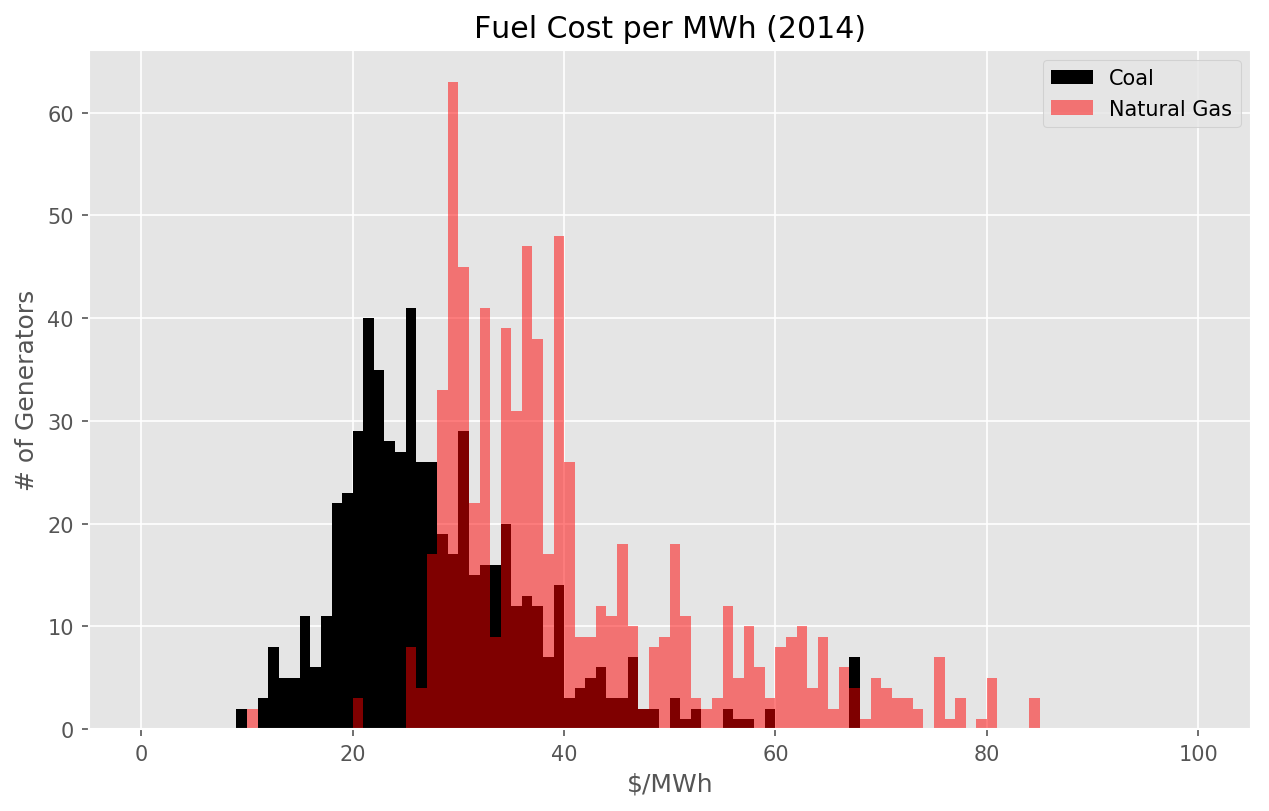

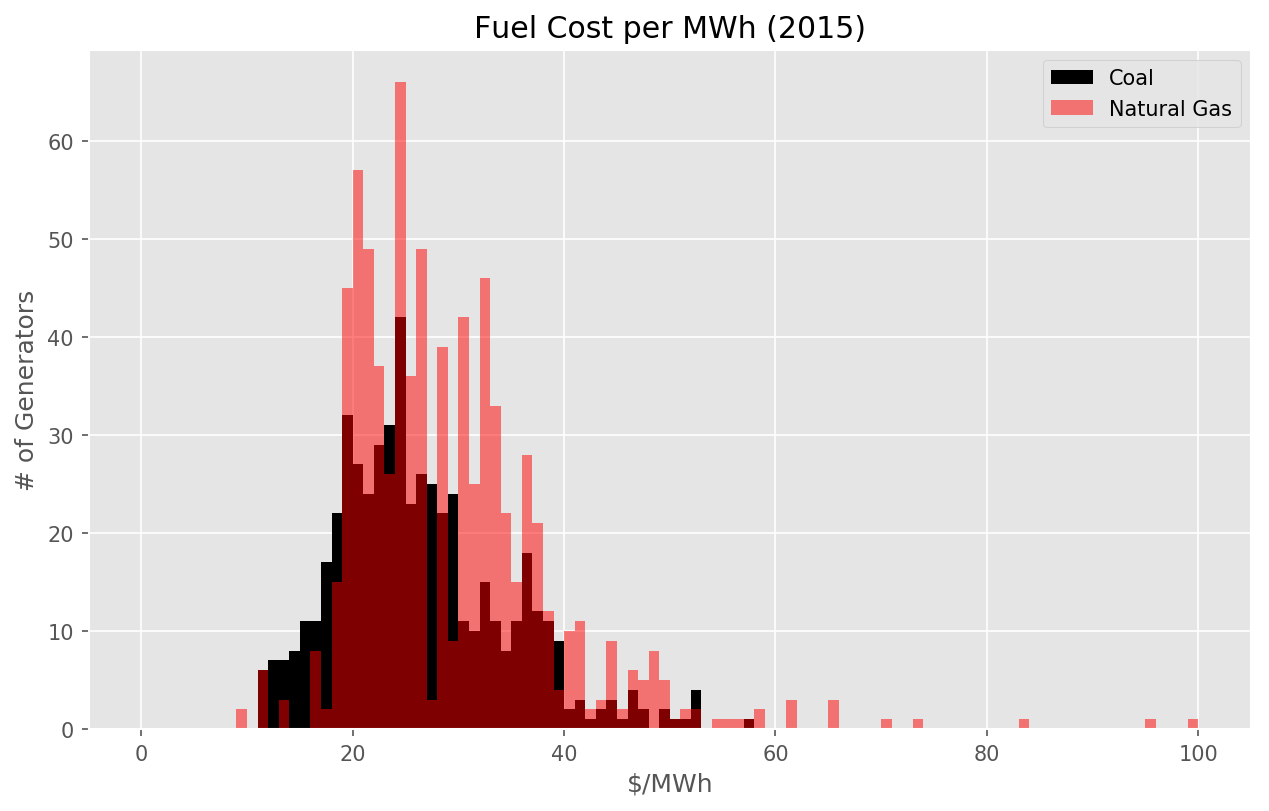

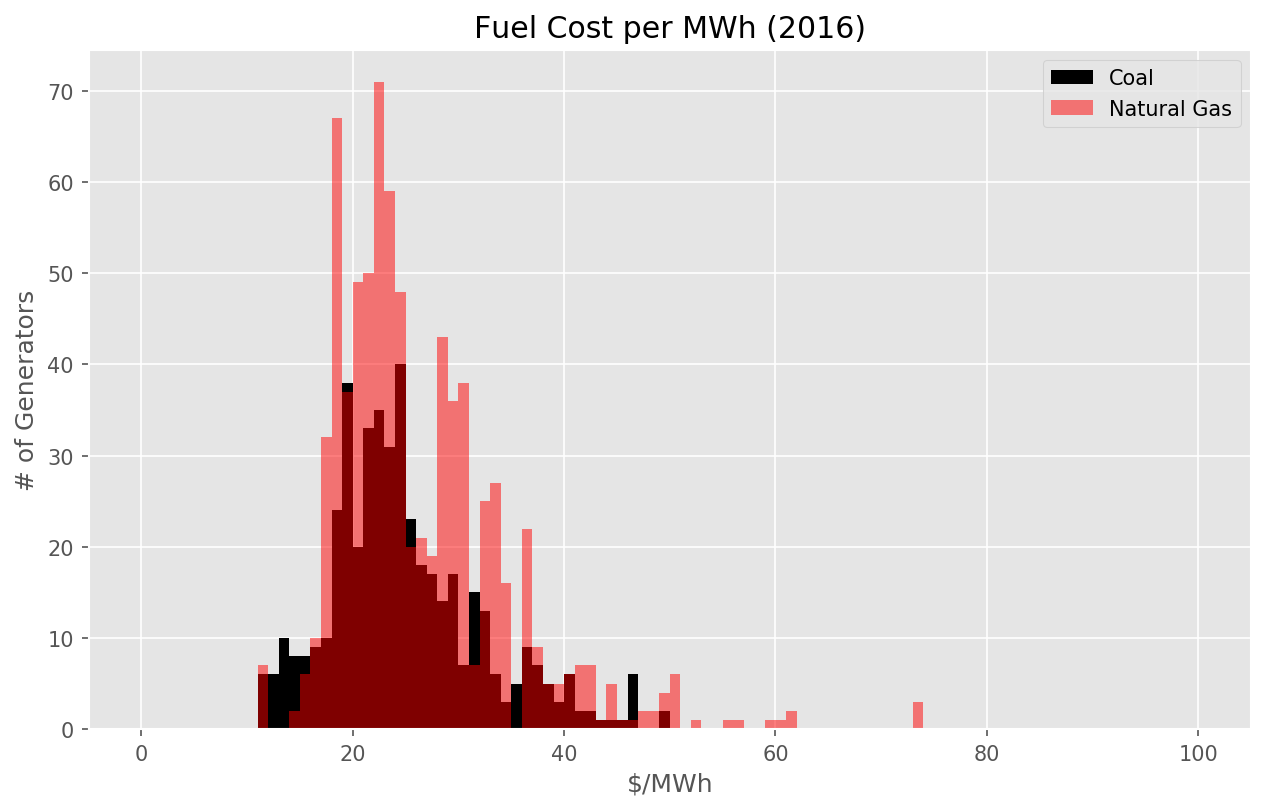

In [41]:
yrs = [2014, 2015, 2016]

for yr in yrs:
    coal_cost = fuel_cost[(fuel_cost.energy_source_cons == 'coal') &
                          (fuel_cost.report_year==yr)].fuel_cost_per_mwh.dropna()
    gas_cost = fuel_cost[(fuel_cost.energy_source_cons == 'gas') &
                         (fuel_cost.report_year==yr)].fuel_cost_per_mwh.dropna()

    plt.hist(coal_cost, bins=100, range=(0,100), color='black', label='Coal')
    plt.hist(gas_cost, bins=100, range=(0,100), color='red', label='Natural Gas', alpha=0.5)

    plt.xlabel("$/MWh")
    plt.ylabel("# of Generators")
    plt.title("Fuel Cost per MWh ({})".format(yr))
    plt.legend()
    plt.show();

In [44]:
fuel_cost[fuel_cost.plant_id_eia==470]

,report_year,plant_id_eia,plant_id_pudl,generator_id,energy_source_cons,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh
119,2014,470,123,1,coal,1.585014,19.654067
120,2014,470,123,2,coal,1.585014,16.690573
121,2014,470,123,3,coal,1.585014,15.780548
2395,2015,470,123,1,coal,1.476165,17.923953
2396,2015,470,123,2,coal,1.476165,15.685234
2397,2015,470,123,3,coal,1.476165,14.581357
4676,2016,470,123,1,coal,1.434824,17.932274
4677,2016,470,123,2,coal,1.434824,14.873731
4678,2016,470,123,3,coal,1.434824,14.058392


## Guts....

Prepping for simplifying fuel cost function

In [ ]:
# for use in simplifying the fuel cost funciton
plant_types = {'one_fuel': (g8_es[g8_es['energy_source_count'] == 1], frc9_summed_plant),
               'multi_fuel': (g8_es[g8_es['energy_source_count'] > 1], frc9_summed)}

In [ ]:
plant_types['multi_fuel'][1]

In [ ]:
for plants in plant_types:
    print(plants)

### Creation of the fuel cost calc

In [ ]:
one_fuel_plants = g8_es[g8_es['energy_source_count'] == 1]

In [ ]:
multi_fuel_plants = g8_es[g8_es['energy_source_count'] > 1]

OhMiGosh Actually calculating Fuel Cost

In [ ]:
# Multi Fuel Method

In [ ]:
net_gen_multi_fuel = g9_summed.merge(multi_fuel_plants, how='left', on=[
                          'plant_id_eia', 'generator_id','report_year'])
net_gen_multi_fuel.dropna(inplace=True)

# Merge this net_gen table with frc9_summed to have
# fuel_cost_per_mmbtu_total associated with generators
fuel_cost_per_mmbtu_multi_fuel = net_gen_multi_fuel.merge(frc9_summed,
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year',
                                        'energy_source_cons'])

fuel_cost_multi_fuel = fuel_cost_per_mmbtu_multi_fuel.merge(heat_rate[['plant_id_eia',
                                                 'report_year',
                                                 'generator_id',
                                                 'net_generation_mwh',
                                                 'heat_rate_mmbtu_mwh']],
                                      on=['plant_id_eia',
                                          'report_year',
                                          'generator_id',
                                          'net_generation_mwh'])

# Calculate fuel cost per mwh using average fuel cost given year, plant,
# fuel type; divide by generator-specific heat rate
fuel_cost_multi_fuel['fuel_cost_per_mwh'] = (fuel_cost_multi_fuel['fuel_cost_per_mmbtu_average'] * fuel_cost_multi_fuel['heat_rate_mmbtu_mwh'])

In [ ]:
fuel_cost_multi_fuel[fuel_cost_multi_fuel.fuel_cost_per_mwh.isnull()].count()

In [ ]:
# One Fuel Method

In [ ]:
net_gen_one_fuel = g9_summed.merge(one_fuel_plants, how='left', on=[
                          'plant_id_eia', 'generator_id','report_year'])
net_gen_one_fuel.dropna(inplace=True)

# Merge this net_gen table with frc9_summed_plant to have
# fuel_cost_per_mmbtu_total associated with generators
fuel_cost_per_mmbtu_one_fuel = net_gen_one_fuel.merge(frc9_summed_plant,
                                   how='left',
                                    on=['plant_id_eia',
                                        'report_year'])

fuel_cost_one_fuel = fuel_cost_per_mmbtu_one_fuel.merge(heat_rate[['plant_id_eia',
                                                 'report_year',
                                                 'generator_id',
                                                 'net_generation_mwh',
                                                 'heat_rate_mmbtu_mwh']],
                                      on=['plant_id_eia',
                                          'report_year',
                                          'generator_id',
                                         'net_generation_mwh'])

# Calculate fuel cost per mwh using average fuel cost given year, plant,
# fuel type; divide by generator-specific heat rate
fuel_cost_one_fuel['fuel_cost_per_mwh'] = (fuel_cost_one_fuel['fuel_cost_per_mmbtu_average']
                                  * fuel_cost_one_fuel['heat_rate_mmbtu_mwh'])

In [ ]:
# Squish them together!
fuel_cost = fuel_cost_one_fuel.append(fuel_cost_multi_fuel)

In [ ]:
fuel_cost_coal = fuel_cost[fuel_cost['energy_source_cons'] == 'coal']
fuel_cost_coal.describe()

In [ ]:
fuel_cost_gas = fuel_cost[fuel_cost['energy_source_cons'] == 'gas']
fuel_cost_gas.describe()

In [ ]:
fuel_cost_gas.net_generation_mwh.sum()

In [ ]:
fuel_cost_coal.describe()

In [ ]:
#plt.hist(mmbtu_one_fuel_bit.mmbtu_propotion_es, range=(.4,1), bins=100, alpha=0.5, color='green', label="BIT")
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='blue', label="oil",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='brown', label="gas", weights=fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='black', label="coal",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].net_generation_mwh)
plt.xlabel("$/MWh")
plt.ylabel("MWh")
plt.title("Fuel Cost per MWh")
plt.legend();

In [ ]:
fuel_cost_gas[fuel_cost_gas.fuel_cost.isnull()]

### Exploration of missing fuel costs.

In [ ]:
# The frc9 pull is being done in a formula now from outputs and is thus not needed for calculating heat rate
# But it's useful for checking missing fuel costs from the original frc table
frc9 = analysis.simple_select_with_pudl_plant_id('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])
frc9['mmbtu'] =  (frc9['fuel_quantity'] * frc9['average_heat_content'])

frc9['energy_source_cons'] = frc9.energy_source.copy()

for energy_source_cons in constants.energy_source_map.keys():
    for energy_source in constants.energy_source_map[energy_source_cons]:
        frc9.loc[frc9.energy_source==energy_source, 'energy_source_cons'] = energy_source_cons 

In [ ]:
# Are we missing data from frc, or is there not cost info?
missing_in_frc = fuel_cost_one_fuel[fuel_cost_one_fuel.fuel_cost.isnull()]
missing_in_frc = missing_in_frc[['plant_id_eia','report_year']].drop_duplicates()
frc9['report_year'] = pd.to_datetime(frc9.report_date).dt.year
missing = missing_in_frc.merge(frc9,left_on=['plant_id_eia','report_year'],right_on=['plant_id_eia','report_year'])
missing[~missing.fuel_cost_per_mmbtu.isnull()]
# It apears that there are no missing frc records that actually have a fuel cost record. 

### Exploration into portion of naturual gas for startup fuel from coal plants

In [ ]:
frc9_summed = frc9_summed.rename(columns={'energy_source':'energy_source_fuel'})
one_fuel_plants = one_fuel_plants.rename(columns={'energy_source':'energy_source_plant'})

frc9_summed = frc9_summed.rename(columns={'energy_source_cons':'energy_source_cons_fuel'})
one_fuel_plants = one_fuel_plants.rename(columns={'energy_source_cons':'energy_source_cons_plant'})

In [ ]:
mmbtu_one_fuel_es = frc9_summed.merge(one_fuel_plants.drop_duplicates(subset=['plant_id_eia','energy_source_plant','report_year']),
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year'])
# we'll merge with a total plant mmbtu, so we need to rename the per energy_source mmtbu
# we also need to drop all the NaN columns bc they are the multi fuel plants
# we also only need a few columns
mmbtu_one_fuel_es = mmbtu_one_fuel_es.rename(columns={'mmbtu': 'mmbtu_es'})\
                                     .dropna()\
                                     .drop(['fuel_cost',
                                            'fuel_cost_per_mmbtu_average',
                                            'generator_id',
                                            'energy_source_count'],axis=1)

In [ ]:
mmbtu_one_fuel_plant = frc9_summed_plant.merge(one_fuel_plants.drop_duplicates(subset=['plant_id_eia','energy_source_plant','report_year']),
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year'])
mmbtu_one_fuel_plant = mmbtu_one_fuel_plant.rename(columns={'mmbtu': 'mmbtu_plant'})\
                                           .dropna()\
                                           .drop(['fuel_cost',
                                                  'fuel_cost_per_mmbtu_average',
                                                  'generator_id',
                                                  'energy_source_count'],axis=1)

In [ ]:
mmbtu_one_fuel = mmbtu_one_fuel_es.merge(mmbtu_one_fuel_plant,how='left',on=['plant_id_eia','report_year','energy_source_plant','energy_source_cons_plant'])


In [ ]:
mmbtu_one_fuel['mmbtu_propotion_es'] = mmbtu_one_fuel['mmbtu_es']/mmbtu_one_fuel['mmbtu_plant']

In [ ]:
mmbtu_one_fuel[mmbtu_one_fuel['energy_source_cons_fuel'] == 'coal'].count()

In [ ]:
mmbtu_one_fuel_coal = mmbtu_one_fuel[(mmbtu_one_fuel['energy_source_cons_plant'] == 'coal') & 
                                    (mmbtu_one_fuel['energy_source_cons_fuel'] == 'coal')]

In [ ]:
mmbtu_one_fuel_coal[mmbtu_one_fuel_coal['mmbtu_propotion_es'] < .8].drop_duplicates(subset=['plant_id_eia'])

In [ ]:
mmbtu_one_fuel_coal.describe()

In [ ]:
plt.hist(mmbtu_one_fuel_coal.mmbtu_propotion_es, range=(.9,1), bins=100, alpha=0.5, color='black', label="coal")
plt.xlabel("Proportion")
plt.ylabel("Number of records")
plt.title("Proportion of Coal Receipts")
plt.legend();

Additional problem exploration...

In [ ]:
# There are some generators out of 27,000 that don't have records in the generators table
# A chunk of these appear to be plants that are retired mid-way through a year
# this will be fixed when we pull in the retired tab into the generators table.
# A chunk of these appear to be genertors added after 2016. This should be fiexed
# when we pull in 2016 data.
test = g9_summed.merge(net_gen_one_fuel.append(net_gen_multi_fuel),how='left')
test[test.energy_source.isnull()].count()